In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N" -O gun.zip && rm -rf /tmp/cookies.txt

--2020-07-29 16:52:44--  https://docs.google.com/uc?export=download&confirm=pZ7I&id=13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N
Resolving docs.google.com (docs.google.com)... 108.177.15.101, 108.177.15.102, 108.177.15.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.15.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-68-docs.googleusercontent.com/docs/securesc/r0qlm8agb43su0j57s24g1kkdmm9a58c/v5lmofuqdn9bij166s4peqk99r628gmv/1596041550000/15439536785859459434/08528284653326803057Z/13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N?e=download [following]
--2020-07-29 16:52:44--  https://doc-0s-68-docs.googleusercontent.com/docs/securesc/r0qlm8agb43su0j57s24g1kkdmm9a58c/v5lmofuqdn9bij166s4peqk99r628gmv/1596041550000/15439536785859459434/08528284653326803057Z/13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N?e=download
Resolving doc-0s-68-docs.googleusercontent.com (doc-0s-68-docs.googleusercontent.com)... 173.194.76.132, 2a00:1450:400c:c00::84
Connecting

In [ ]:
!unzip gun.zip

Archive:  gun.zip
replace gun_data/Gun/02230413128b12b274a9cb65f3509466a3af-700.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!mkdir gun_data/train/

In [ ]:
!mv gun_data/Gun/ gun_data/train/
!mv gun_data/Not_Gun/ gun_data/train/ 

In [ ]:
#let's import all the libraries:

# all pytorch libraries
import torch
import torchvision as tv
from torchvision import datasets, transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset

# all necessary libraris
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

broken_files = []
for i in os.listdir('/content/gun_data/train/Not_Gun'):
  try:
    filename = '/content/gun_data/train/Not_Gun/'+i
    im = Image.open(filename)
    im.verify() #I perform also verify, don't know if he sees other types o defects
    im.close() #reload is necessary in my case
    im = Image.open(filename) 
    im.transpose(Image.FLIP_LEFT_RIGHT)
    im.close()
  except Exception as e: 
    print(e,i)
    broken_files.append(filename)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
for i in broken_files:
  os.remove(i)

In [ ]:
# Checkwhich device you're using
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
print(device)

cuda:0


In [ ]:
data_dir = '/content/gun_data/train'

augmentations = [transforms.Resize((224,224)),
                 transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(augmentations))
print(len(dataset))


def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    my_dataset = {}
    my_dataset['train'] = Subset(dataset, train_idx)
    my_dataset['val'] = Subset(dataset, val_idx)
    return my_dataset

my_dataset = train_val_dataset(dataset)
print(len(my_dataset['train']))
print(len(my_dataset['val']))
# The original dataset is available in the Subset class
print(my_dataset['train'].dataset)

12881
10304
2577
Dataset ImageFolder
    Number of datapoints: 12881
    Root location: /content/gun_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
BATCH_SIZE = 64
dataloaders = {x: torch.utils.data.DataLoader(my_dataset[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=1) for x in ['train', 'val']}

In [ ]:
classes = list(my_dataset['train'].dataset.class_to_idx.keys())
dataiter = iter(dataloaders['train'])

dataset_sizes = {x: len(my_dataset[x]) for x in ['train', 'val']}

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
classes,dataset_sizes

(['Gun', 'Not_Gun'], {'train': 10304, 'val': 2577})

In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f63aac9a320>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f63aac9a198>}

In [ ]:
#images has 32 images from our train dataloader
images[31] , labels[31]

(tensor([[[ 0.3481,  0.3481,  0.3994,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.3481,  0.3481,  0.3994,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.3652,  0.3652,  0.4166,  ..., -0.0287, -0.0458, -0.0458],
          ...,
          [-0.0629, -0.0629, -0.0801,  ..., -0.3541, -0.2513, -0.1486],
          [ 0.6734,  0.6906,  0.6563,  ..., -0.1828, -0.1486, -0.1486],
          [ 1.1872,  1.2043,  1.1700,  ..., -0.0458, -0.1314, -0.2684]],
 
         [[ 1.3431,  1.3431,  1.3431,  ...,  1.1155,  1.0980,  1.0980],
          [ 1.3431,  1.3431,  1.3606,  ...,  1.1155,  1.1155,  1.1155],
          [ 1.3606,  1.3606,  1.3606,  ...,  1.1331,  1.1155,  1.1155],
          ...,
          [ 0.8179,  0.8179,  0.8179,  ..., -0.9153, -0.8102, -0.7052],
          [ 1.3606,  1.3606,  1.3782,  ..., -0.7752, -0.7402, -0.7402],
          [ 1.6933,  1.7108,  1.6933,  ..., -0.6702, -0.7577, -0.8978]],
 
         [[ 2.2566,  2.2566,  2.2217,  ...,  2.2043,  2.1868,  2.1868],
          [ 2.2566,  2.2566,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


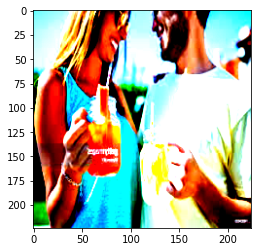

In [ ]:
tnsn_np = images[31].numpy()
plt.imshow(np.transpose(tnsn_np,(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

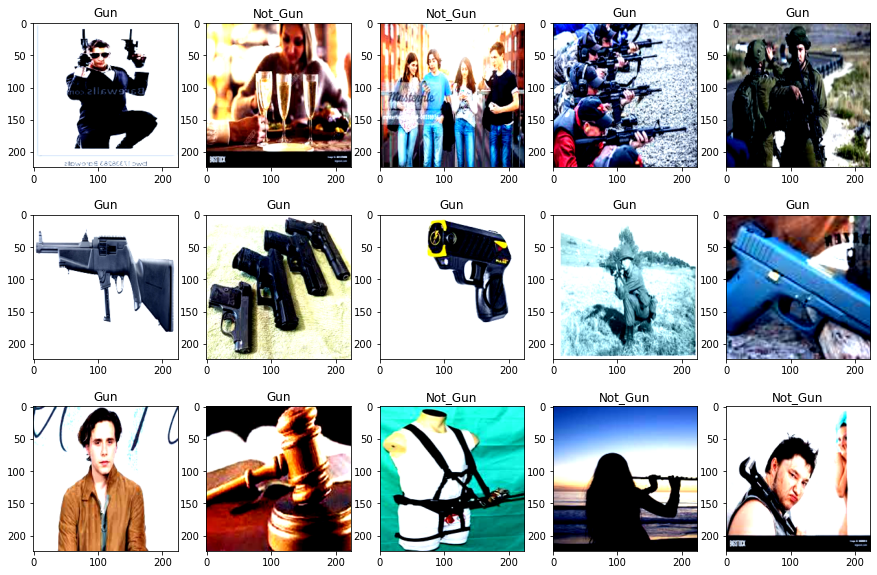

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

classes = {0: 'Gun', 1: 'Not_Gun'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) 
        ax.set(title ="{}".format(classes[label.item()]))

In [ ]:
images.shape

torch.Size([64, 3, 224, 224])

In [ ]:
model_ft = tv.models.resnet50(pretrained=True)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print("model_ft")
for i, param in enumerate(model_ft.named_parameters()):
    pass
    print(i, param[0], param[1].requires_grad)
    # param.requires_grad = False

model_ft
0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.0.conv3.weight True
10 layer1.0.bn3.weight True
11 layer1.0.bn3.bias True
12 layer1.0.downsample.0.weight True
13 layer1.0.downsample.1.weight True
14 layer1.0.downsample.1.bias True
15 layer1.1.conv1.weight True
16 layer1.1.bn1.weight True
17 layer1.1.bn1.bias True
18 layer1.1.conv2.weight True
19 layer1.1.bn2.weight True
20 layer1.1.bn2.bias True
21 layer1.1.conv3.weight True
22 layer1.1.bn3.weight True
23 layer1.1.bn3.bias True
24 layer1.2.conv1.weight True
25 layer1.2.bn1.weight True
26 layer1.2.bn1.bias True
27 layer1.2.conv2.weight True
28 layer1.2.bn2.weight True
29 layer1.2.bn2.bias True
30 layer1.2.conv3.weight True
31 layer1.2.bn3.weight True
32 layer1.2.bn3.bias True
33 layer2.0.conv1.weight True
34 layer2.0.bn1.weight True
35 layer2.0.bn1.bias 

In [ ]:
# # now we have data in dataloader with batch 32
# # Let's build our neural network

# class GunClassifier(nn.Module):
#   def __init__(self,input_dim):
#     super(GunClassifier,self).__init__()

#     self.input_layer = nn.Linear(input_dim,256)
    
#     self.hidden_1 = nn.Linear(256,512)
#     self.dropout = nn.Dropout(0.3,True)

#     self.hidden_2 = nn.Linear(512,512)
#     self.dropout2 = nn.Dropout(0.5,True)

#     self.hidden_3 = nn.Linear(512,256)
#     self.dropout3 = nn.Dropout(0.3,True)

#     self.hidden_4 = nn.Linear(256,128)
#     self.output = nn.Linear(128,2)

#   def forward(self,x):
#     x = F.relu(self.input_layer(x))
#     #print("shape is",x.shape)

#     x = F.relu(self.hidden_1(x))
#     #print("shape is",x.shape)

#     x = F.relu(self.hidden_2(x))
#     #print("shape is",x.shape)

#     x = F.relu(self.hidden_3(x))
#     #print("shape is",x.shape)

#     x = F.relu(self.hidden_4(x))
#     #print("shape is",x.shape)

#     output = F.log_softmax(self.output(x),dim=1) 
#     return output

class GunCNN(nn.Module):
  def __init__(self):
    super(GunCNN,self).__init__()

    # [(W−K+2P)/S]+1
    # if input width = 128 kernel = 3, padd = 1, stride = 1 ,then  Output_Width = [(128-3+2)/1] + 1 = 128

    # input shape - 3x416x416 guess the output - ? 224
    self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
    
            #input shape = 16x416 output - ? 224 
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.Dropout(0.2),
    
            #input - 64x207x51 111
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        
            #input - 128x24x102 54
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.4),
            
            # 102 54
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            #27
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5))

  
    #input - 512x12x12
    self.linear_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(256*13*13, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.4),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(0.5),

            nn.Linear(128, 2))
    
  def forward(self,x):
    x = self.conv_layers(x)
    output = self.linear_layers(x)
    return F.log_softmax(output)



model_ft = tv.models.resnet50(pretrained=True)

for i, param in enumerate(model_ft.named_parameters()):
    param[1].requires_grad = False
    #print(i)
    if i >= 150: #"layer3.1.conv2.weight True":
        param[1].requires_grad = True

num_ftrs = model_ft.fc.in_features
print("num_ftrs: ", num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

###alternate model defining but not working properly
class FineTuneModel(nn.Module):
    def __init__(self, original_model, num_filters, num_classes):
        super().__init__()
        self.body = nn.Sequential(*(list(original_model.children())[:-1]))
        self.head = nn.Sequential(
                        nn.BatchNorm1d(num_filters),
                        nn.Dropout(0.5),
                        nn.Linear(num_filters, 512),
                        nn.ReLU(True),
                        nn.BatchNorm1d(512),
                        nn.Dropout(0.5),
                        nn.Linear(512, num_classes),
                    )

    def forward(self, x):
        f = self.body(x)
        # f = torch.flatten(f)
        f = f.view(f.size(0), -1)
        y = F.log_softmax(self.head(f))
        return y


# class GunCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#             # [(W−K+2P)/S]+1
#             # if input width = 128 kernel = 3, padd = 1, stride = 1 ,then  Output_Width = [(128-3+2)/1] + 1 = 128

#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), 

#             #208
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             #104
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             #52
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             #26
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), 
            
#             #6
#             nn.Flatten(), 
#             nn.Linear(256*6*6, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 2))
        
#     def forward(self, xb):
#         return F.log_softmax(self.network(xb))


input_dim = 3*416*416
# gun_clf = GunCNN()
gun_clf =  FineTuneModel(model_ft, num_ftrs, 2)
gun_clf

num_ftrs:  2048


FineTuneModel(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [ ]:
# outputs = gun_clf(images)
# outputs

In [ ]:
# _,preds = torch.max(outputs, dim=1)
# preds,labels.data

In [ ]:
# # Result before Training

# dataiter = iter(dataloaders['val'])
# images, labels = dataiter.next()
# classes = {0: 'Gun', 1: 'Not_Gun'}
# # Viewing data examples used for training
# fig, axis = plt.subplots(3, 5, figsize=(15, 10))
# with torch.no_grad():
#     gun_clf.eval().to(device)
#     image_tensor = images.to(device)
#     output_ = gun_clf(image_tensor)
#     for ax, output_,image, label in zip(axis.flat,outputs,images, labels):
#         ax.imshow(img_display(image)) # add image
#         output_ = output_.argmax()
#         k = output_.item()==label.item()
#         ax.set_title(str(classes[label.item()])+":" +str(k)) # add label

In [ ]:
# almost all are False, which is okay since model is predicting anything randomly.

In [ ]:
import time
import os
import copy
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gun_clf.parameters(), lr=0.001)
gun_clf = gun_clf.to(device)
criterion = criterion.to(device)

n_epochs = 6
best_acc = 0.0
best_model_wts = copy.deepcopy(gun_clf.state_dict())
since = time.time()
val_loss,val_acc,train_loss,train_acc = [],[],[],[]

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,5], gamma=0.1)
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(dataloaders['train']), epochs=20)

for epoch in range(1, n_epochs+1):
    print('Epoch {}/{}'.format(epoch, n_epochs))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
          gun_clf.train()  # Set model to training mode
      else:
          gun_clf.eval()   # Set model to evaluate mode
    
      running_loss = 0.0
      running_corrects = 0
      print('phase = ',phase)
      for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = gun_clf(inputs)
          loss = criterion(outputs, labels)
          _,preds = torch.max(outputs, dim=1)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if batch_idx%10==0:
          print("{} of {} ; loss: {}".format(batch_idx, dataset_sizes[phase] // BATCH_SIZE, loss))

      if phase == 'train':
          scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'train':
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
      else:
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(gun_clf.state_dict())
          torch.save(gun_clf.state_dict(), 'best_epoch'+str(epoch)+'.pth')

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))
 

Epoch 1/6
phase =  train


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0 of 161 ; loss: 0.9539741277694702


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 161 ; loss: 0.47106218338012695
20 of 161 ; loss: 0.2019311636686325
30 of 161 ; loss: 0.14844396710395813
40 of 161 ; loss: 0.1662779301404953
50 of 161 ; loss: 0.20513364672660828
60 of 161 ; loss: 0.11921969801187515
70 of 161 ; loss: 0.3746841251850128
80 of 161 ; loss: 0.14000923931598663
90 of 161 ; loss: 0.2186099886894226
100 of 161 ; loss: 0.18407286703586578
110 of 161 ; loss: 0.19418403506278992
120 of 161 ; loss: 0.17274516820907593
130 of 161 ; loss: 0.09600777924060822
140 of 161 ; loss: 0.1499270647764206
150 of 161 ; loss: 0.108189657330513
160 of 161 ; loss: 0.12110638618469238
train Loss: 0.2252 Acc: 0.9113
phase =  val
0 of 40 ; loss: 0.20551402866840363


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.20359186828136444
20 of 40 ; loss: 0.13715410232543945
30 of 40 ; loss: 0.10344039648771286
40 of 40 ; loss: 0.08014365285634995
val Loss: 0.1573 Acc: 0.9418
Epoch 2/6
phase =  train
0 of 161 ; loss: 0.11290664225816727


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 161 ; loss: 0.07921738922595978
20 of 161 ; loss: 0.1902623325586319
30 of 161 ; loss: 0.23691731691360474
40 of 161 ; loss: 0.08841187506914139
50 of 161 ; loss: 0.15026742219924927
60 of 161 ; loss: 0.14578917622566223
70 of 161 ; loss: 0.13133634626865387
80 of 161 ; loss: 0.16094844043254852
90 of 161 ; loss: 0.1613306850194931
100 of 161 ; loss: 0.11937449127435684
110 of 161 ; loss: 0.0782899558544159
120 of 161 ; loss: 0.17490532994270325
130 of 161 ; loss: 0.10460247844457626
140 of 161 ; loss: 0.28295889496803284
150 of 161 ; loss: 0.1334385722875595
160 of 161 ; loss: 0.08287286013364792
train Loss: 0.1502 Acc: 0.9428
phase =  val
0 of 40 ; loss: 0.2816615104675293


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.15017233788967133
20 of 40 ; loss: 0.22148741781711578
30 of 40 ; loss: 0.16802765429019928
40 of 40 ; loss: 0.04172661527991295
val Loss: 0.1498 Acc: 0.9492
Epoch 3/6
phase =  train


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0 of 161 ; loss: 0.17450979351997375
10 of 161 ; loss: 0.04708944633603096
20 of 161 ; loss: 0.1424441635608673
30 of 161 ; loss: 0.03137194737792015
40 of 161 ; loss: 0.06527919322252274
50 of 161 ; loss: 0.08740063011646271
60 of 161 ; loss: 0.057039663195610046
70 of 161 ; loss: 0.09252402186393738
80 of 161 ; loss: 0.12517179548740387
90 of 161 ; loss: 0.19653233885765076
100 of 161 ; loss: 0.028534743934869766
110 of 161 ; loss: 0.13287581503391266
120 of 161 ; loss: 0.043291427195072174
130 of 161 ; loss: 0.2127787172794342
140 of 161 ; loss: 0.1258823424577713
150 of 161 ; loss: 0.05148237943649292
160 of 161 ; loss: 0.08444007486104965
train Loss: 0.0978 Acc: 0.9651
phase =  val
0 of 40 ; loss: 0.09511888027191162
10 of 40 ; loss: 0.13776683807373047
20 of 40 ; loss: 0.13459323346614838
30 of 40 ; loss: 0.10259886831045151


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40 of 40 ; loss: 0.3375844359397888
val Loss: 0.1387 Acc: 0.9515
Epoch 4/6
phase =  train
0 of 161 ; loss: 0.06968535482883453
10 of 161 ; loss: 0.10626382380723953


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.012675909325480461
30 of 161 ; loss: 0.042031656950712204
40 of 161 ; loss: 0.07238490134477615
50 of 161 ; loss: 0.02674175053834915
60 of 161 ; loss: 0.1823371797800064
70 of 161 ; loss: 0.07859864085912704
80 of 161 ; loss: 0.23461788892745972
90 of 161 ; loss: 0.027797900140285492
100 of 161 ; loss: 0.0440639853477478
110 of 161 ; loss: 0.03439826890826225
120 of 161 ; loss: 0.08516588807106018
130 of 161 ; loss: 0.18992681801319122
140 of 161 ; loss: 0.11580187827348709
150 of 161 ; loss: 0.07525186985731125
160 of 161 ; loss: 0.06125129014253616
train Loss: 0.0728 Acc: 0.9753
phase =  val
0 of 40 ; loss: 0.09043492376804352
10 of 40 ; loss: 0.05105912685394287
20 of 40 ; loss: 0.16821816563606262


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30 of 40 ; loss: 0.10393095761537552
40 of 40 ; loss: 0.0686166062951088
val Loss: 0.1363 Acc: 0.9519
Epoch 5/6
phase =  train


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0 of 161 ; loss: 0.04740253835916519
10 of 161 ; loss: 0.02034955658018589
20 of 161 ; loss: 0.03216150030493736
30 of 161 ; loss: 0.05863432586193085
40 of 161 ; loss: 0.09442100673913956
50 of 161 ; loss: 0.07596717029809952
60 of 161 ; loss: 0.03096839040517807
70 of 161 ; loss: 0.2726882994174957
80 of 161 ; loss: 0.02438708208501339
90 of 161 ; loss: 0.08110827952623367
100 of 161 ; loss: 0.044461317360401154
110 of 161 ; loss: 0.03525589406490326
120 of 161 ; loss: 0.017199350520968437
130 of 161 ; loss: 0.04757128283381462
140 of 161 ; loss: 0.013705089688301086
150 of 161 ; loss: 0.056695155799388885
160 of 161 ; loss: 0.023195253685116768
train Loss: 0.0598 Acc: 0.9793
phase =  val
0 of 40 ; loss: 0.02692483738064766
10 of 40 ; loss: 0.09429293125867844
20 of 40 ; loss: 0.20483705401420593
30 of 40 ; loss: 0.15237312018871307


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40 of 40 ; loss: 0.3053428828716278
val Loss: 0.1387 Acc: 0.9546
Epoch 6/6
phase =  train


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0 of 161 ; loss: 0.008642842061817646
10 of 161 ; loss: 0.0946439653635025
20 of 161 ; loss: 0.013425705023109913
30 of 161 ; loss: 0.237092986702919
40 of 161 ; loss: 0.06438423693180084
50 of 161 ; loss: 0.05408370867371559
60 of 161 ; loss: 0.04078427329659462
70 of 161 ; loss: 0.05410462245345116
80 of 161 ; loss: 0.013758021406829357
90 of 161 ; loss: 0.12173453718423843
100 of 161 ; loss: 0.02865351364016533
110 of 161 ; loss: 0.015607116743922234
120 of 161 ; loss: 0.04168694466352463
130 of 161 ; loss: 0.020867228507995605
140 of 161 ; loss: 0.1694098860025406
150 of 161 ; loss: 0.16428004205226898
160 of 161 ; loss: 0.05660177022218704
train Loss: 0.0580 Acc: 0.9786
phase =  val
0 of 40 ; loss: 0.09342952817678452
10 of 40 ; loss: 0.15659494698047638
20 of 40 ; loss: 0.22757980227470398


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30 of 40 ; loss: 0.14455565810203552
40 of 40 ; loss: 0.026958370581269264
val Loss: 0.1339 Acc: 0.9527
Training complete in 10m 30s
Best val Acc: 0.954598


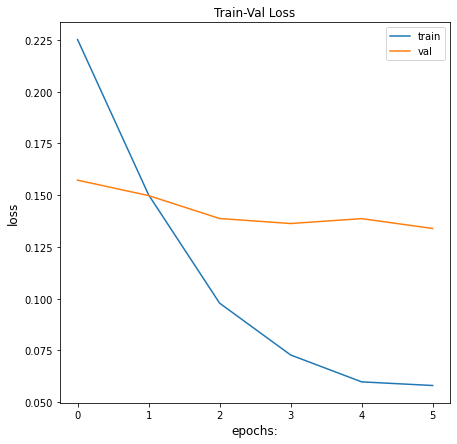

In [ ]:
 # 77,79,80,82,82
fig = plt.figure(figsize=(7,7))
plt.title("Train-Val Loss")
plt.plot(train_loss,label='train')
plt.plot(val_loss, label = 'val')
plt.xlabel('epochs:',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.legend(loc='best')

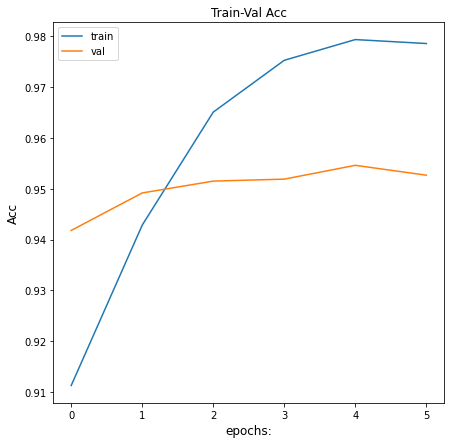

In [ ]:
 fig = plt.figure(figsize=(7,7))
plt.title("Train-Val Acc")
plt.plot(train_acc,label='train')
plt.plot(val_acc, label = 'val')
plt.xlabel('epochs:',fontsize=12)
plt.ylabel('Acc',fontsize=12)
plt.legend(loc='best')

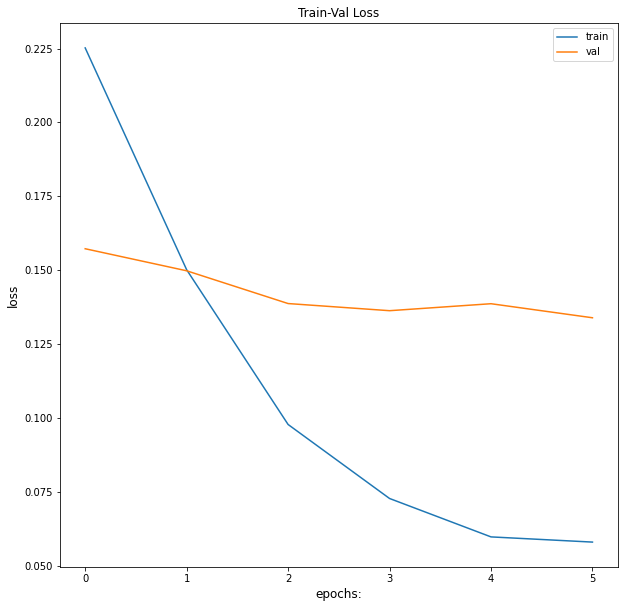

In [ ]:
# 77,79,80,82,82
fig = plt.figure(figsize=(10,10))
plt.title("Train-Val Loss")
plt.plot(train_loss,label='train')
plt.plot(val_loss, label = 'val')
plt.xlabel('epochs:',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.legend(loc='best')

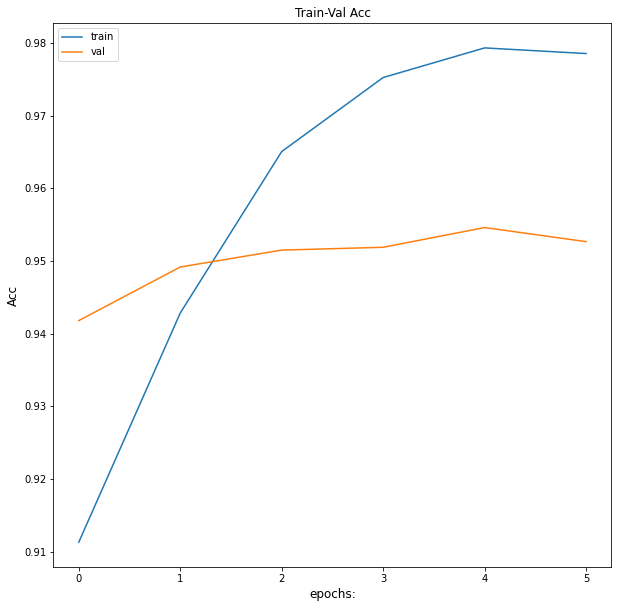

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.title("Train-Val Acc")
plt.plot(train_acc,label='train')
plt.plot(val_acc, label = 'val')
plt.xlabel('epochs:',fontsize=12)
plt.ylabel('Acc',fontsize=12)
plt.legend(loc='best')

In [ ]:
# Result before Training

dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
classes = {0: 'Gun', 1: 'Not_Gun'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    gun_clf.eval().to(device)
    image_tensor = images.to(device)
    output_ = gun_clf(image_tensor)
    for ax, output_,image, label in zip(axis.flat,outputs,images, labels):
        ax.imshow(img_display(image)) # add image
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(classes[label.item()])+":" +str(k)) # add label

In [ ]:
#importing the required libraries
import numpy as np
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt
%matplotlib inline

#reading the image 
image = imread('Corona-Virus.jpg',as_gray=True)
print(image)

[[0.62029412 0.62421569 0.62588235 ... 0.82060667 0.8166851  0.8166851 ]
 [0.62029412 0.62029412 0.62588235 ... 0.82060667 0.8166851  0.8166851 ]
 [0.62029412 0.62029412 0.62588235 ... 0.82060667 0.82060667 0.82060667]
 ...
 [0.8454149  0.8454149  0.8454149  ... 0.66864667 0.66864667 0.66864667]
 [0.8454149  0.8454149  0.8454149  ... 0.66864667 0.66864667 0.66864667]
 [0.84933647 0.84933647 0.84933647 ... 0.66864667 0.66864667 0.66864667]]


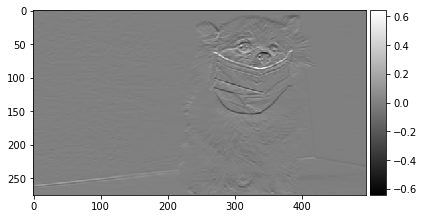

In [ ]:
#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(image)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(image)

imshow(edges_prewitt_horizontal, cmap='gray')

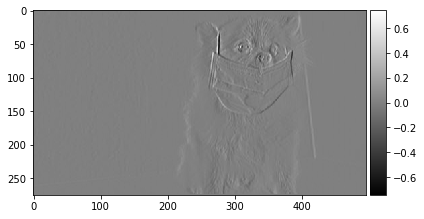

In [ ]:
imshow(edges_prewitt_vertical, cmap='gray')

In [ ]:
num = {5:4,
       2:54}
num

{2: 54, 5: 4}

In [ ]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
le.fit(train_df.landmark_id.values)
print('found classes', len(le.classes_))
assert len(le.classes_) == num_classes

train_df.landmark_id = le.transform(train_df.landmark_id)


[7808, 6907, 8683, 8551, 9980, 9205, 1]

In [ ]:
import pandas as pd
df = pd.DataFrame({'class_':[23,45,67]})
df

,class_
0,23
1,45
2,67


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df.class_)

LabelEncoder()

In [ ]:
print('found classes', len(le.classes_))

found classes 3
